### Loading Libraries

In [61]:
import numpy as np 
import matplotlib.pyplot as plt
import random

In [15]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras import backend
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from datetime import datetime
import cv2 
from IPython import display
import seaborn as sns 
sns.set_style("darkgrid")
import glob

#!pip install -U tensorflow_datasets

### Loading dataset with pre-processing & init global variables

In [16]:
def noise_generator(batch=1,_shape=100):
  return tf.random.normal([batch, _shape])

HEIGHT = 64
WIDTH = 64
BUFFER_SIZE = 60000
BATCH_SIZE = 256
split = 'train'
DIM = 100
seed = noise_generator(100,DIM)
SAVE_PATH = "./ANN/results/"
def preprocess(img):
    return (tf.image.resize(img, [HEIGHT, WIDTH]) - 127.5) / 127.5


def load_dataset(count=False):
    paths = glob.glob("./ANN/PetImages/Cat/*.jpg")
    paths += glob.glob("./ANN/PetImages/Dog/*.jpg")
    random.shuffle(paths)
    if count != False :
        paths = paths[:count]
    Images = []
    for p in paths: 
        try:
            img = cv2.imread(p)
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            img = preprocess(img)
            Images.append(img)
        except:
            print(p)
    Images = np.array(Images)
    Images = np.array_split(Images, BATCH_SIZE)
    return Images
    
dataset = load_dataset(10000)

./ANN/PetImages/Cat/7978.jpg
./ANN/PetImages/Cat/3491.jpg
./ANN/PetImages/Dog/11853.jpg
./ANN/PetImages/Cat/9171.jpg
./ANN/PetImages/Cat/850.jpg
./ANN/PetImages/Cat/10125.jpg
./ANN/PetImages/Dog/5604.jpg
./ANN/PetImages/Dog/7969.jpg
./ANN/PetImages/Cat/666.jpg
./ANN/PetImages/Dog/3588.jpg
./ANN/PetImages/Dog/2877.jpg
./ANN/PetImages/Dog/10158.jpg
./ANN/PetImages/Dog/4367.jpg
./ANN/PetImages/Dog/5736.jpg


Corrupt JPEG data: 226 extraneous bytes before marker 0xd9


./ANN/PetImages/Cat/10820.jpg
./ANN/PetImages/Cat/2663.jpg
./ANN/PetImages/Dog/6718.jpg
./ANN/PetImages/Cat/3300.jpg
./ANN/PetImages/Cat/5553.jpg


Corrupt JPEG data: 254 extraneous bytes before marker 0xd9


./ANN/PetImages/Cat/140.jpg


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


### Plot some sample

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

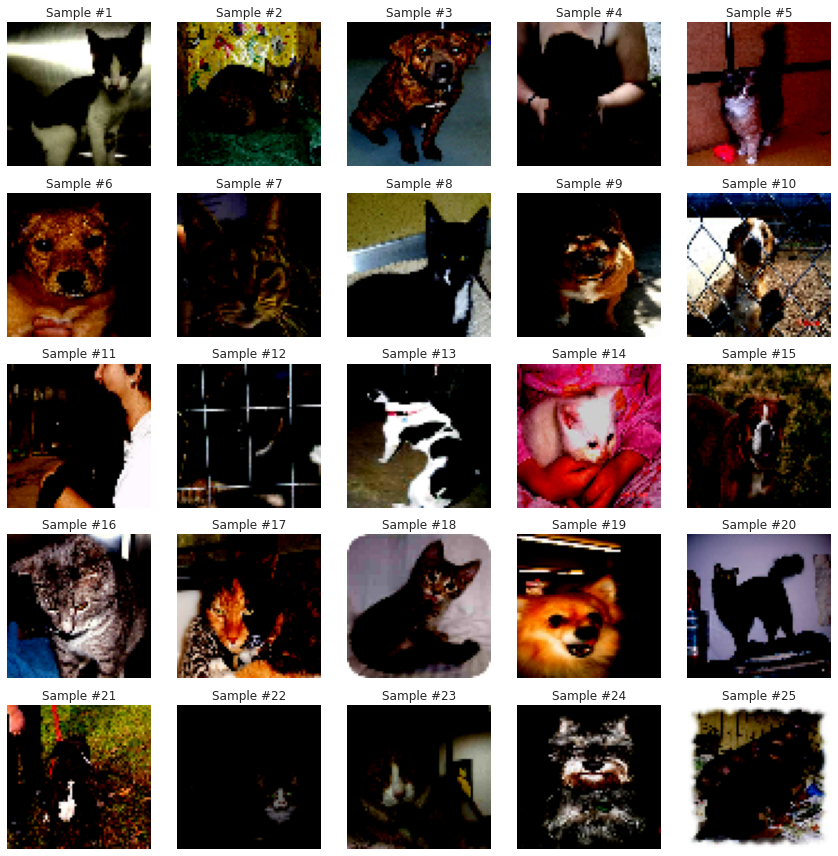

In [17]:
plt.rcParams["figure.figsize"] = (12,12)
for tmp in dataset:
  for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(tmp[i+1,:,:,:])
    plt.title("Sample #{0}".format(i+1))
    plt.axis("off")
  plt.tight_layout()
  plt.show()
  break


### Ploting and saving function to monitor and store weight

In [18]:
from datetime import datetime

def SaveImages(images,e,t):
    now = datetime.now()
    path_ = now.strftime("%d %m-%H %M %S") + "- {0} - {1}.jpg".format(e,t)
    _h = []
    res = []
    for i in range(100):
        img = images[i,:,:,:]
        img += 1 
        img *= 127.5 
        img = img.astype("uint8")
        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        _h.append(img)
        if i % 10 == 9 and i != 0:
            out = cv2.hconcat(_h)
            res.append(out)
            _h = []

    out = cv2.vconcat(res)
    cv2.imwrite(SAVE_PATH+path_,out)

def SaveModels(t,epoch):
  global generator
  global discriminator
  global gan_model
  now = datetime.now()
  path_ = SAVE_PATH + now.strftime("%d %m-%H %M %S") + "- {1} - {0} - ".format(epoch,t)
  generator.save(path_+"GEN.h5")
  discriminator.save(path_+"DISC.h5")
  gan_model.save(path_+"GAN.h5")

def SaveChart(loss,t="Stacked"):
  plt.rcParams["figure.figsize"] = (6,6)
  plt.plot(loss[0],label="Generator loss")
  plt.plot(loss[1],label="Discriminator loss")
  plt.title("Loss/Epoch | "+t)
  plt.xlabel("Epoch")
  plt.ylabel("Binary Crossentropy")
  plt.legend()
  now = datetime.now()
  path_ = SAVE_PATH + now.strftime("%d %m-%H %M %S") + "- loss {0} .png".format(t)
  plt.savefig(path_)
  plt.clf()


def SaveArch():
  global generator
  global discriminator
  global gan_model
  now = datetime.now()
  path_ = SAVE_PATH + now.strftime("%d %m-%H %M %S")
  keras.utils.plot_model(generator,show_dtype=True,show_shapes=True,expand_nested=True,
                         dpi=120,to_file=path_+" GEN Arch.png")
  keras.utils.plot_model(discriminator,show_dtype=True,show_shapes=True,expand_nested=True,
                         dpi=120,to_file=path_+" DISC Arch.png")
  keras.utils.plot_model(gan_model,show_dtype=True,show_shapes=True,expand_nested=True,
                         dpi=120,to_file=path_+" GAN Arch.png")
  


### DCGAN Makers

In [70]:
from tensorflow.keras.initializers import RandomNormal
def generator_dc(_shape=100,de_con_count = 4):
    node = _shape
    model = tf.keras.Sequential()
    if de_con_count == 1 :
        start_size = 32
    if de_con_count == 2 :
        start_size = 16
    if de_con_count == 3 :
        start_size = 8
    if de_con_count == 4 :
        start_size = 4
        
    model = Sequential()
    model.add(Dense(start_size*start_size*256, kernel_initializer=RandomNormal(0, 0.02), input_dim=_shape))
    model.add(ReLU())
    model.add(Reshape((start_size, start_size, 256)))
    
    for _ in range(de_con_count):
        model.add(Conv2DTranspose(256, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.01)))
        model.add(BatchNormalization(momentum=0.1,  epsilon=0.8))
        model.add(ReLU())
    
    model.add(Conv2D(3, (3, 3), padding='same', activation='tanh', kernel_initializer=RandomNormal(0, 0.01)))
    return model

def discriminator_dc():
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(WIDTH, WIDTH, 3)))
    model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    model.add(LeakyReLU(0.2))

    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    return model

### FCGAN Makers

In [22]:
def generator_fc(_shape=100,_layers = []):
		node = _shape
		model = tf.keras.Sequential()
		model.add(Input(shape=(_shape,)))
	
		for l in _layers:
			model.add(layers.Dense(units=l))
			model.add(layers.BatchNormalization(momentum=0.1,  epsilon=0.8))
			model.add(LeakyReLU(0.2))
		
		model.add(layers.Dense(HEIGHT*WIDTH*3, activation="tanh"))
		model.add(Reshape((HEIGHT,WIDTH,3)))
	
		return model

def discriminator_fc():
		model = tf.keras.Sequential()
		model.add(Input(shape=(HEIGHT,HEIGHT,3)))
		model.add(Flatten())
		for u in [512,256,128,16]:
			model.add(Dense(u))
			model.add(LeakyReLU(0.2))

		model.add(Dense(1,activation="sigmoid"))
		return model

### Train GANs :

In [34]:
backend.clear_session()
optimizer = keras.optimizers.RMSprop(lr=0.0008,clipvalue=1.0,decay=1e-15)
generator = generator_fc(DIM,[1024,4096])
#generator.compile(loss='binary_crossentropy', optimizer=optimizer)
generator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.00075, 0.5))

discriminator = discriminator_fc()
optimizer = keras.optimizers.RMSprop(lr=0.0002,clipvalue=1.0,decay=1e-15)
#discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
discriminator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.00075, 0.5))

discriminator.trainable = False

_in = Input(shape=(DIM,))
g_out = generator(_in)
disc_out = discriminator(g_out)
gan_model = keras.models.Model(inputs=_in,outputs=disc_out)
optimizer = keras.optimizers.RMSprop(lr=0.0008,clipvalue=1.0,decay=1e-15)
#gan_model.compile(loss='binary_crossentropy', optimizer=optimizer)
gan_model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.00075, 0.5))



In [44]:
def TrainStackLoop(epochs,no_rate=0):
  global generator
  global discriminator
  global gan_model
  dis_loss = []
  gen_loss = []
  for epoch in range(epochs):
    """if epoch%20 == 0:
        c = input("Continue? ")
        if int(c) != 1 :
            out_images = generator.predict(seed)
            SaveImages(out_images,epochs,"Stacked-FCGAB")
            return gen_loss , dis_loss
    """
    start = time.time()
    batch_count = 0
    dis_batch_loss = 0
    gen_batch_loss = 0
    for batch in dataset : 
      #if batch_count%30 ==0:
      #print("batch count: ",batch_count," - ",round(time.time() - start,2))
      batch = np.array(batch)
      if no_rate!= 0 :
        batch += np.random.normal(0, no_rate, size=(batch.shape[0], HEIGHT,WIDTH,3))

      _noise = noise_generator(batch.shape[0],DIM)
      fake_x = generator.predict(_noise)
      x = np.concatenate((batch, fake_x))

      disc_y = np.zeros(2*batch.shape[0])
      disc_y[:batch.shape[0]] = 1

      d_loss = discriminator.train_on_batch(x, disc_y)
      dis_batch_loss += d_loss

      y_gen = np.ones(batch.shape[0])
      g_loss = gan_model.train_on_batch(_noise, y_gen)
      gen_batch_loss += g_loss

      batch_count += 1 
    
    end = round(time.time() - start,2)
    print("Time for Epoch {0} is {1} | disc loss : {2} | gen loss {3}".format(epoch+1,end,dis_batch_loss/batch_count,gen_batch_loss/batch_count))
    gen_loss.append(gen_batch_loss/batch_count)
    dis_loss.append(dis_batch_loss/batch_count)
    if epoch%5 == 0 and epoch != 0 :
      out_images = generator.predict(seed)
      SaveImages(out_images,epoch+1,"Stacked-DCGAB")

  out_images = generator.predict(seed)
  SaveImages(out_images,epochs,"Stacked-DCGAB")
  return gen_loss , dis_loss
  



In [47]:
backend.clear_session()
generator = generator_dc()
generator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.00075, 0.5))

discriminator = discriminator_dc()
discriminator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.00075, 0.5))

discriminator.trainable = False

_in = Input(shape=(DIM,))
g_out = generator(_in)
disc_out = discriminator(g_out)
gan_model = keras.models.Model(inputs=_in,outputs=disc_out)
gan_model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.00075, 0.5))


losses = TrainStackLoop(150,0)
SaveModels("Stacked-DCGAB",150)
SaveChart(losses)
SaveArch()

Time for Epoch 1 is 34.3 | disc loss : 0.6122429556320412 | gen loss 1.7744239640887827
Time for Epoch 2 is 25.61 | disc loss : 0.6796079643536359 | gen loss 0.8552132351323962
Time for Epoch 3 is 25.63 | disc loss : 0.6838308640290052 | gen loss 0.8239587338175625
Time for Epoch 4 is 25.61 | disc loss : 0.6909736494999379 | gen loss 0.8115696667227894
Time for Epoch 5 is 26.67 | disc loss : 0.6856635096482933 | gen loss 0.8403356506023556
Time for Epoch 6 is 26.43 | disc loss : 0.688990288763307 | gen loss 0.8857839126139879
Time for Epoch 7 is 26.15 | disc loss : 0.6389612620696425 | gen loss 1.8219410217134282
Time for Epoch 8 is 26.04 | disc loss : 0.5789220384322107 | gen loss 2.237607387069147
Time for Epoch 9 is 25.87 | disc loss : 0.5030885037849657 | gen loss 2.694783744867891
Time for Epoch 10 is 25.63 | disc loss : 0.46796534716850147 | gen loss 2.8339616233715788
Time for Epoch 11 is 25.85 | disc loss : 0.43896514223888516 | gen loss 3.88844523858279
Time for Epoch 12 is 27

Time for Epoch 93 is 27.11 | disc loss : 0.3546664718305692 | gen loss 2.6507328496081755
Time for Epoch 94 is 26.59 | disc loss : 0.3383645676076412 | gen loss 2.80132975615561
Time for Epoch 95 is 26.34 | disc loss : 0.41557883721543476 | gen loss 2.5181544036604464
Time for Epoch 96 is 26.24 | disc loss : 0.3550271001877263 | gen loss 2.6966043011052534
Time for Epoch 97 is 26.02 | disc loss : 0.34728623990667984 | gen loss 2.7585978590650484
Time for Epoch 98 is 25.89 | disc loss : 0.40709777461597696 | gen loss 2.721514733042568
Time for Epoch 99 is 26.65 | disc loss : 0.35642257501604035 | gen loss 2.6458962864708155
Time for Epoch 100 is 26.88 | disc loss : 0.3502483090851456 | gen loss 2.7596302716992795
Time for Epoch 101 is 26.67 | disc loss : 0.3624314935586881 | gen loss 2.773522906238213
Time for Epoch 102 is 26.33 | disc loss : 0.3418838503130246 | gen loss 2.9234601092757657
Time for Epoch 103 is 26.16 | disc loss : 1.0964173830871005 | gen loss 3.2578110668837326
Time f

<Figure size 432x432 with 0 Axes>

In [53]:
losses = TrainStackLoop(100,0)
SaveModels("Stacked-DCGAB",100)
SaveChart(losses)
SaveArch()

Time for Epoch 1 is 25.27 | disc loss : 0.36620578632573597 | gen loss 2.714684855309315
Time for Epoch 2 is 25.29 | disc loss : 0.3306382847367786 | gen loss 2.97885683295317
Time for Epoch 3 is 26.59 | disc loss : 0.34198535230825655 | gen loss 2.8878969808574766
Time for Epoch 4 is 26.21 | disc loss : 0.31014221932855435 | gen loss 3.030585328815505
Time for Epoch 5 is 25.73 | disc loss : 0.319427486800123 | gen loss 2.9618599810637534
Time for Epoch 6 is 25.44 | disc loss : 0.36071855115005746 | gen loss 3.1294145587598905
Time for Epoch 7 is 25.61 | disc loss : 0.3273849817633163 | gen loss 2.957857246743515
Time for Epoch 8 is 25.53 | disc loss : 0.34189380166935734 | gen loss 3.0327991601079702
Time for Epoch 9 is 26.21 | disc loss : 0.34370302635943517 | gen loss 3.046927232760936
Time for Epoch 10 is 26.59 | disc loss : 0.3900158767646644 | gen loss 2.790853084414266
Time for Epoch 11 is 26.32 | disc loss : 0.3275916304264683 | gen loss 2.964353572577238
Time for Epoch 15 is 2

Time for Epoch 96 is 26.2 | disc loss : 0.3043208230228629 | gen loss 3.0049134513828903
Time for Epoch 97 is 26.0 | disc loss : 0.29689725692151114 | gen loss 3.3097571046091616
Time for Epoch 98 is 27.12 | disc loss : 0.32626258867094293 | gen loss 3.2459846331039444
Time for Epoch 99 is 27.04 | disc loss : 0.2818159944145009 | gen loss 3.275378606747836
Time for Epoch 100 is 26.48 | disc loss : 0.40087905738619156 | gen loss 3.2003679729095893


<Figure size 432x432 with 0 Axes>

In [54]:
backend.clear_session()
generator = generator_dc(de_con_count=3)
generator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.00075, 0.5))

discriminator = discriminator_dc()
discriminator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.00025, 0.5))

discriminator.trainable = False

_in = Input(shape=(DIM,))
g_out = generator(_in)
disc_out = discriminator(g_out)
gan_model = keras.models.Model(inputs=_in,outputs=disc_out)
gan_model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.00075, 0.5))


losses = TrainStackLoop(250,0)
SaveModels("Stacked-DCGAB",250)
SaveChart(losses)
SaveArch()

Time for Epoch 1 is 33.9 | disc loss : 0.6876484181266278 | gen loss 0.8055990316206589
Time for Epoch 2 is 26.03 | disc loss : 0.6939773694612086 | gen loss 0.7200777131365612
Time for Epoch 3 is 26.69 | disc loss : 0.6933525903150439 | gen loss 0.7001045709475875
Time for Epoch 4 is 27.04 | disc loss : 0.6934790327213705 | gen loss 0.7126697576604784
Time for Epoch 5 is 27.18 | disc loss : 0.6935313823632896 | gen loss 0.6966856333892792
Time for Epoch 6 is 26.73 | disc loss : 0.6931639586109668 | gen loss 0.6983644496649504
Time for Epoch 7 is 26.47 | disc loss : 0.6931315455585718 | gen loss 0.7212311634793878
Time for Epoch 8 is 26.27 | disc loss : 0.6928699670825154 | gen loss 0.7012024624273181
Time for Epoch 9 is 25.94 | disc loss : 0.693454364547506 | gen loss 0.7136641985271126
Time for Epoch 10 is 26.56 | disc loss : 0.6755561026511714 | gen loss 0.8780085030011833
Time for Epoch 11 is 27.09 | disc loss : 0.657440674956888 | gen loss 0.942465819651261
Time for Epoch 12 is 27

Time for Epoch 93 is 27.06 | disc loss : 0.4913134635426104 | gen loss 1.4536867616698146
Time for Epoch 94 is 26.57 | disc loss : 0.4992592731723562 | gen loss 1.5029311130056158
Time for Epoch 95 is 26.33 | disc loss : 0.5030165902571753 | gen loss 1.4458203283138573
Time for Epoch 96 is 26.04 | disc loss : 0.5015921578742564 | gen loss 1.4839301842730492
Time for Epoch 97 is 26.08 | disc loss : 0.4893289052415639 | gen loss 1.5019465174991637
Time for Epoch 98 is 26.65 | disc loss : 0.5367979024304077 | gen loss 1.4935630910331383
Time for Epoch 99 is 27.08 | disc loss : 0.49695117154624313 | gen loss 1.472767232451588
Time for Epoch 100 is 27.1 | disc loss : 0.48432057606987655 | gen loss 1.5323560037650168
Time for Epoch 101 is 26.56 | disc loss : 0.4794407245935872 | gen loss 1.542223643627949
Time for Epoch 102 is 26.26 | disc loss : 0.4868257048074156 | gen loss 1.5675381927285343
Time for Epoch 103 is 26.16 | disc loss : 0.47849217895418406 | gen loss 1.5915871990146115
Time f

Time for Epoch 184 is 26.29 | disc loss : 0.38342135841958225 | gen loss 2.0880820797756314
Time for Epoch 185 is 26.14 | disc loss : 0.41877642524195835 | gen loss 2.0546524595702067
Time for Epoch 186 is 26.01 | disc loss : 0.36724601755850017 | gen loss 2.128202445106581
Time for Epoch 187 is 27.34 | disc loss : 0.38031123380642384 | gen loss 2.0967969656921923
Time for Epoch 188 is 27.34 | disc loss : 0.43828257406130433 | gen loss 2.045924811041914
Time for Epoch 189 is 26.64 | disc loss : 0.3850772001314908 | gen loss 2.03040337190032
Time for Epoch 190 is 26.53 | disc loss : 0.37056267203297466 | gen loss 2.1247454246040434
Time for Epoch 191 is 26.24 | disc loss : 0.3796791796339676 | gen loss 2.1157709087710828
Time for Epoch 192 is 26.01 | disc loss : 0.3700345275574364 | gen loss 2.156959088984877
Time for Epoch 193 is 26.75 | disc loss : 0.36787749401992187 | gen loss 2.16590855573304
Time for Epoch 194 is 26.96 | disc loss : 0.37096059863688424 | gen loss 2.154068690491840

<Figure size 432x432 with 0 Axes>

In [55]:
backend.clear_session()
generator = generator_dc(de_con_count=3)
generator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.00075, 0.5))

discriminator = discriminator_dc()
discriminator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.00025, 0.5))

discriminator.trainable = False

_in = Input(shape=(DIM,))
g_out = generator(_in)
disc_out = discriminator(g_out)
gan_model = keras.models.Model(inputs=_in,outputs=disc_out)
gan_model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.00075, 0.5))


losses = TrainStackLoop(250,0.1)
SaveModels("Stacked-DCGAB",250)
SaveChart(losses)
SaveArch()

Time for Epoch 1 is 32.88 | disc loss : 0.6845789163271547 | gen loss 1.2669232555199414
Time for Epoch 2 is 30.81 | disc loss : 0.6861305509228259 | gen loss 0.7432110683294013
Time for Epoch 3 is 32.0 | disc loss : 0.6898069797316566 | gen loss 0.758926059352234
Time for Epoch 4 is 31.94 | disc loss : 0.6916840435005724 | gen loss 0.7022699271328747
Time for Epoch 5 is 31.68 | disc loss : 0.693293106276542 | gen loss 0.7092617060989141
Time for Epoch 6 is 31.49 | disc loss : 0.6922562394756824 | gen loss 0.7081005701329559
Time for Epoch 7 is 30.96 | disc loss : 0.6940465257503092 | gen loss 0.7447925168089569
Time for Epoch 8 is 30.84 | disc loss : 0.6927436667028815 | gen loss 0.7024215362034738
Time for Epoch 9 is 30.9 | disc loss : 0.6929863318800926 | gen loss 0.6993782566860318
Time for Epoch 10 is 32.07 | disc loss : 0.6925402579363436 | gen loss 0.701224360615015
Time for Epoch 11 is 31.93 | disc loss : 0.6932916711084545 | gen loss 0.708997932029888
Time for Epoch 12 is 31.6

Time for Epoch 93 is 31.68 | disc loss : 0.5445243183057755 | gen loss 1.3193707480095327
Time for Epoch 94 is 31.37 | disc loss : 0.545163088478148 | gen loss 1.3424447618890554
Time for Epoch 95 is 30.99 | disc loss : 0.5486840059747919 | gen loss 1.3673066426999867
Time for Epoch 96 is 30.91 | disc loss : 0.5551351773319766 | gen loss 1.3108318198937923
Time for Epoch 97 is 30.89 | disc loss : 0.5442610742757097 | gen loss 1.3244915632531047
Time for Epoch 98 is 32.22 | disc loss : 0.5476633891230449 | gen loss 1.3533624368719757
Time for Epoch 99 is 32.08 | disc loss : 0.5449346706736833 | gen loss 1.3424372065346688
Time for Epoch 100 is 31.41 | disc loss : 0.5429876410635188 | gen loss 1.3518825434148312
Time for Epoch 101 is 31.07 | disc loss : 0.5414511766284704 | gen loss 1.3254593685269356
Time for Epoch 102 is 30.83 | disc loss : 0.5389744091080502 | gen loss 1.310593981994316
Time for Epoch 103 is 30.86 | disc loss : 0.5430705574108288 | gen loss 1.3701113238930702
Time for

Time for Epoch 184 is 30.87 | disc loss : 0.45884921529795974 | gen loss 1.637130631133914
Time for Epoch 185 is 30.86 | disc loss : 0.4605658588698134 | gen loss 1.6652128351852298
Time for Epoch 186 is 32.15 | disc loss : 0.4581766524352133 | gen loss 1.6470945780165493
Time for Epoch 187 is 32.18 | disc loss : 0.45173496729694307 | gen loss 1.6801680515054613
Time for Epoch 188 is 31.59 | disc loss : 0.4712188832927495 | gen loss 1.6357730235904455
Time for Epoch 189 is 31.09 | disc loss : 0.452159266336821 | gen loss 1.675445303088054
Time for Epoch 190 is 30.94 | disc loss : 0.4571968134259805 | gen loss 1.6764271424617618
Time for Epoch 191 is 30.77 | disc loss : 0.4669282934628427 | gen loss 1.65309494943358
Time for Epoch 192 is 31.56 | disc loss : 0.44535955582978204 | gen loss 1.7083296519704163
Time for Epoch 193 is 31.77 | disc loss : 0.4569216235540807 | gen loss 1.6742000670637935
Time for Epoch 194 is 32.1 | disc loss : 0.44921642693225294 | gen loss 1.6975777503103018
T

<Figure size 432x432 with 0 Axes>

In [56]:
backend.clear_session()
generator = generator_dc(de_con_count=3)
generator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.00075, 0.5))

discriminator = discriminator_dc()
discriminator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.00025, 0.5))

discriminator.trainable = False

_in = Input(shape=(DIM,))
g_out = generator(_in)
disc_out = discriminator(g_out)
gan_model = keras.models.Model(inputs=_in,outputs=disc_out)
gan_model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.00075, 0.5))


losses = TrainStackLoop(250,0.2)
SaveModels("Stacked-DCGAB",250)
SaveChart(losses)
SaveArch()

Time for Epoch 1 is 32.49 | disc loss : 0.6706717813794967 | gen loss 0.9712095881113783
Time for Epoch 2 is 31.72 | disc loss : 0.6604027834255248 | gen loss 1.0252210160251707
Time for Epoch 3 is 31.82 | disc loss : 0.5794088187394664 | gen loss 1.5682322387583554
Time for Epoch 4 is 31.72 | disc loss : 0.6327503443462774 | gen loss 1.2255183048546314
Time for Epoch 5 is 30.98 | disc loss : 0.6475518789375201 | gen loss 1.143678535008803
Time for Epoch 6 is 30.74 | disc loss : 0.6166900590760633 | gen loss 1.636874373536557
Time for Epoch 7 is 30.69 | disc loss : 0.4986140690743923 | gen loss 2.7084634765051305
Time for Epoch 8 is 30.59 | disc loss : 0.4890087439562194 | gen loss 3.004752525128424
Time for Epoch 9 is 31.84 | disc loss : 0.4725094764435198 | gen loss 3.3164975121617317
Time for Epoch 10 is 31.95 | disc loss : 0.455868044286035 | gen loss 3.2616128949448466
Time for Epoch 11 is 31.6 | disc loss : 0.49655632488429546 | gen loss 3.118264884920791
Time for Epoch 12 is 31.

Time for Epoch 93 is 31.13 | disc loss : 0.3355834990506992 | gen loss 3.288428188301623
Time for Epoch 94 is 30.78 | disc loss : 0.28134020941797644 | gen loss 3.195532301440835
Time for Epoch 95 is 30.88 | disc loss : 0.31574077816912904 | gen loss 3.2753067617304623
Time for Epoch 96 is 30.72 | disc loss : 0.28117521325475536 | gen loss 3.1154666584916413
Time for Epoch 97 is 31.89 | disc loss : 0.28694338802597485 | gen loss 3.2158836415037513
Time for Epoch 98 is 31.82 | disc loss : 0.2903042365796864 | gen loss 3.087636725511402
Time for Epoch 99 is 31.51 | disc loss : 0.2925582476891577 | gen loss 3.1665368783287704
Time for Epoch 100 is 31.04 | disc loss : 0.28959762799786404 | gen loss 3.155783496797085
Time for Epoch 101 is 30.92 | disc loss : 0.2639358176093083 | gen loss 3.1234887023456395
Time for Epoch 102 is 30.74 | disc loss : 0.33138731733197346 | gen loss 3.4651104169897735
Time for Epoch 103 is 31.07 | disc loss : 0.2950132599216886 | gen loss 3.041973169427365
Time 

Time for Epoch 184 is 30.83 | disc loss : 0.26430280605563894 | gen loss 2.368941484717652
Time for Epoch 185 is 31.84 | disc loss : 0.2716094864590559 | gen loss 2.3522708928212523
Time for Epoch 186 is 31.88 | disc loss : 0.25606734296889044 | gen loss 2.429442245978862
Time for Epoch 187 is 32.09 | disc loss : 0.2552533807756845 | gen loss 2.410248947329819
Time for Epoch 188 is 31.48 | disc loss : 0.25631092401454225 | gen loss 2.4079458843916655
Time for Epoch 189 is 31.1 | disc loss : 0.26358678433462046 | gen loss 2.428014627425
Time for Epoch 190 is 30.58 | disc loss : 0.26028793372097425 | gen loss 2.4160659252665937
Time for Epoch 191 is 30.57 | disc loss : 0.2593145207792986 | gen loss 2.4748767782002687
Time for Epoch 192 is 32.03 | disc loss : 0.24566856361343525 | gen loss 2.4795785071328282
Time for Epoch 193 is 31.85 | disc loss : 0.23866302147507668 | gen loss 2.435028562322259
Time for Epoch 194 is 31.78 | disc loss : 0.2767076466116123 | gen loss 2.4605463594198227
T

<Figure size 432x432 with 0 Axes>

In [ ]:
backend.clear_session()
generator = generator_dc(de_con_count=3)
generator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.00075, 0.5))

discriminator = discriminator_dc()
discriminator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.00025, 0.5))

discriminator.trainable = False

_in = Input(shape=(DIM,))
g_out = generator(_in)
disc_out = discriminator(g_out)
gan_model = keras.models.Model(inputs=_in,outputs=disc_out)
gan_model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.00075, 0.5))


losses = TrainStackLoop(250,0.4)
SaveModels("Stacked-DCGAB",250)
SaveChart(losses)
SaveArch()

Time for Epoch 1 is 33.45 | disc loss : 0.6335557461134158 | gen loss 1.310106608318165
Time for Epoch 2 is 31.75 | disc loss : 0.3662867837556405 | gen loss 4.441457039210945
Time for Epoch 3 is 31.36 | disc loss : 0.32392900651029777 | gen loss 5.193316691671498
Time for Epoch 4 is 31.16 | disc loss : 0.30638744425959885 | gen loss 6.4404099870007485
Time for Epoch 5 is 30.79 | disc loss : 0.32470905836089514 | gen loss 6.657646779902279
Time for Epoch 6 is 31.03 | disc loss : 0.34403612471942324 | gen loss 5.903726221062243
Time for Epoch 7 is 30.83 | disc loss : 0.33956012190901674 | gen loss 5.824545254465193
Time for Epoch 8 is 32.22 | disc loss : 0.3678058514778968 | gen loss 5.267194047570229
Time for Epoch 9 is 31.34 | disc loss : 0.3635471601737663 | gen loss 4.567066445015371
Time for Epoch 10 is 31.36 | disc loss : 0.34622647624928504 | gen loss 6.128757871687412
Time for Epoch 11 is 31.27 | disc loss : 0.38029376717167906 | gen loss 5.420275465585291
Time for Epoch 12 is 3

In [ ]:
backend.clear_session()
generator = generator_dc(de_con_count=2)
generator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.00075, 0.5))

discriminator = discriminator_dc()
discriminator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.00025, 0.5))

discriminator.trainable = False

_in = Input(shape=(DIM,))
g_out = generator(_in)
disc_out = discriminator(g_out)
gan_model = keras.models.Model(inputs=_in,outputs=disc_out)
gan_model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.00075, 0.5))


losses = TrainStackLoop(250,0)
SaveModels("Stacked-DCGAB",250)
SaveChart(losses)
SaveArch()

In [ ]:
backend.clear_session()
generator = generator_dc(de_con_count=1)
generator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.00075, 0.5))

discriminator = discriminator_dc()
discriminator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.00025, 0.5))

discriminator.trainable = False

_in = Input(shape=(DIM,))
g_out = generator(_in)
disc_out = discriminator(g_out)
gan_model = keras.models.Model(inputs=_in,outputs=disc_out)
gan_model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.00075, 0.5))


losses = TrainStackLoop(250,0)
SaveModels("Stacked-DCGAB",250)
SaveChart(losses)
SaveArch()

In [ ]:
backend.clear_session()
generator = generator_dc(de_con_count=3)
generator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.001, 0.5))

discriminator = discriminator_dc()
discriminator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.00075, 0.5))

discriminator.trainable = False

_in = Input(shape=(DIM,))
g_out = generator(_in)
disc_out = discriminator(g_out)
gan_model = keras.models.Model(inputs=_in,outputs=disc_out)
gan_model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.001, 0.5))


losses = TrainStackLoop(1000,0.1)
SaveModels("Stacked-DCGAB",1000)
SaveChart(losses)
SaveArch()

Time for Epoch 1 is 74.77 | disc loss : 0.5465473392414424 | gen loss 2.656122767351917
Time for Epoch 2 is 53.51 | disc loss : 0.5274462838206091 | gen loss 3.5591850126126303
Time for Epoch 3 is 53.75 | disc loss : 0.5490054593101377 | gen loss 1.9267623097111937
Time for Epoch 4 is 53.78 | disc loss : 0.5563029811601155 | gen loss 1.7922380017116666
Time for Epoch 5 is 53.89 | disc loss : 0.5408766914042644 | gen loss 2.3556503802828956
Time for Epoch 6 is 53.92 | disc loss : 0.5421374640136492 | gen loss 2.3129998185904697
Time for Epoch 7 is 55.25 | disc loss : 0.531898563640425 | gen loss 2.7430072793504223
Time for Epoch 8 is 54.97 | disc loss : 0.5148580861859955 | gen loss 2.8528544696164317
Time for Epoch 9 is 54.64 | disc loss : 0.4745967265480431 | gen loss 3.176211846875958
Time for Epoch 10 is 54.28 | disc loss : 0.4652485898695886 | gen loss 4.09268883173354
Time for Epoch 11 is 54.29 | disc loss : 0.3853827409038786 | gen loss 4.664954353123903
Time for Epoch 12 is 54.0

Time for Epoch 93 is 53.98 | disc loss : 0.5148904364323243 | gen loss 1.9226257145637646
Time for Epoch 94 is 53.95 | disc loss : 0.5138991679414175 | gen loss 2.1570284746121615
Time for Epoch 95 is 53.69 | disc loss : 0.5377559193875641 | gen loss 1.9320634895702824
Time for Epoch 96 is 54.54 | disc loss : 0.5129323264118284 | gen loss 2.0000242182286456
Time for Epoch 97 is 54.69 | disc loss : 0.5568320791353472 | gen loss 2.013558251201175
Time for Epoch 98 is 54.81 | disc loss : 0.5114504419034347 | gen loss 1.960206625983119
Time for Epoch 99 is 54.36 | disc loss : 0.5068487062817439 | gen loss 1.9940097369253635
Time for Epoch 100 is 54.01 | disc loss : 0.5059809335507452 | gen loss 2.0909257174353115
Time for Epoch 101 is 53.86 | disc loss : 0.5041293176473118 | gen loss 2.1181234513642266
Time for Epoch 102 is 53.84 | disc loss : 0.5258709456538782 | gen loss 2.0806337407557294
Time for Epoch 103 is 53.66 | disc loss : 0.5028688582242467 | gen loss 2.156511371722445
Time for 

Time for Epoch 184 is 53.67 | disc loss : 0.3813314021390397 | gen loss 2.6956034009344876
Time for Epoch 185 is 53.78 | disc loss : 0.3601119420491159 | gen loss 2.7756880975794047
Time for Epoch 186 is 54.85 | disc loss : 0.3731628435780294 | gen loss 3.032821102300659
Time for Epoch 187 is 54.83 | disc loss : 0.39625512491329573 | gen loss 2.8659890827257186
Time for Epoch 188 is 54.72 | disc loss : 0.3951971106871497 | gen loss 3.1783634359017015
Time for Epoch 189 is 53.91 | disc loss : 0.3672989158658311 | gen loss 3.0989147217478603
Time for Epoch 190 is 53.97 | disc loss : 0.36515532099292614 | gen loss 3.001729844836518
Time for Epoch 191 is 53.77 | disc loss : 0.3683542418293655 | gen loss 3.1919295142870396
Time for Epoch 192 is 53.6 | disc loss : 6.122758665449739 | gen loss 27.1802459598548
Time for Epoch 193 is 53.51 | disc loss : 0.7033931601908989 | gen loss 8.849871423561126
Time for Epoch 194 is 54.7 | disc loss : 0.4001077817811165 | gen loss 3.993931499077007
Time f